In [1]:
import numpy as np
import scipy.stats as sps

import torch
import torchvision

In [2]:
!pip --version

pip 21.3.1 from /home/ilyasm/projects/sudoku/venv/lib/python3.10/site-packages/pip (python 3.10)


In [3]:
import matplotlib.pyplot as plt

In [4]:
import cv2 as cv

In [5]:
img = cv.imread("my_screen_example_0.jpg")

In [6]:
def imshow(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap="gray")
    plt.show()

In [7]:
img = cv.GaussianBlur(img,(5,5), 0)
img = cv.medianBlur(img, 3)
# img = cv.resize(img, (512, 512))
gray = cv.cvtColor(img,cv.COLOR_RGBA2GRAY)

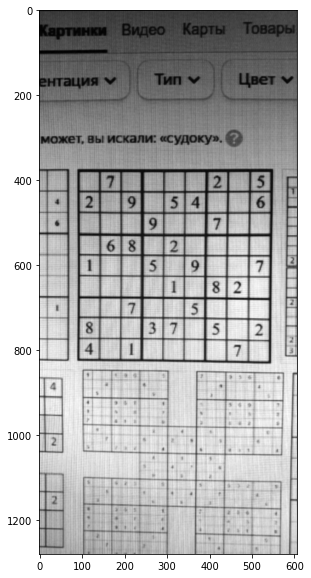

In [8]:
imshow(gray)

In [9]:
canny_img = cv.Canny(gray, 60, 200)

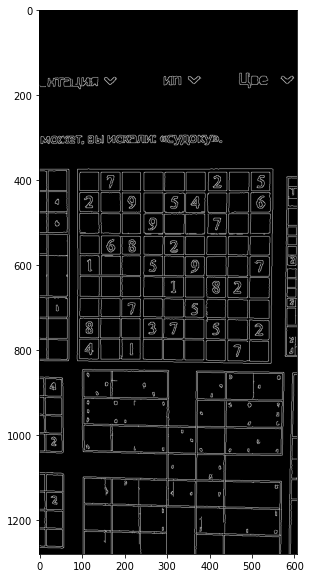

In [10]:
imshow(canny_img)

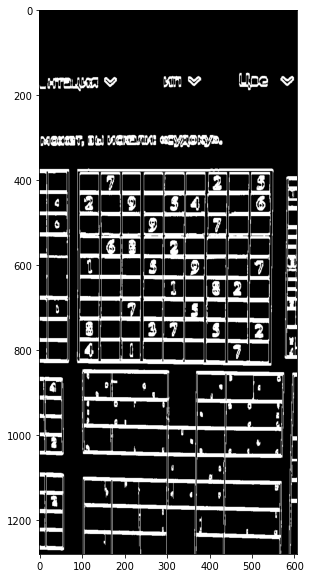

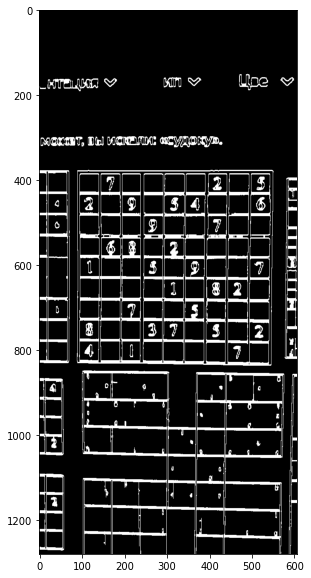

In [11]:
dilated = cv.dilate(canny_img, (3, 3), iterations=5)
imshow(dilated)
eroded = cv.erode(dilated, (5, 5), iterations=3)
imshow(eroded)

In [12]:
ret, thresh = cv.threshold(eroded, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [13]:
elems = sorted(contours, key=lambda x: cv.contourArea(x))

In [14]:
contour = elems[-1]
hull = cv.convexHull(contour)

epsilon = 0.01 * cv.arcLength(hull, True)
bbox = cv.approxPolyDP(hull, epsilon, True)

In [15]:
plt.figure(figsize=(15, 10))
cnt = elems[-1]
cont_img = np.copy(img)

<Figure size 1080x720 with 0 Axes>

In [16]:
def match_corner(points, align):
    return sorted(points, key=lambda x: np.cross(x, align))[-1]

def match_corners(points):
    aligns = [[1, -1], [1, 1], [-1, 1], [-1, -1]]
    return np.array([match_corner(points, align) for align in aligns])

In [17]:
cell_size = 28
bbox_size = 9 * cell_size
new_bbox = np.float32([[0,0],[bbox_size,0],[0,bbox_size],[bbox_size,bbox_size]])
new_bbox = match_corners(new_bbox).astype(np.float32)
prev_bbox = match_corners(hull[:, 0]).astype(np.float32)

M = cv.getPerspectiveTransform(prev_bbox, new_bbox)
dst = cv.warpPerspective(gray, M, (bbox_size, bbox_size))


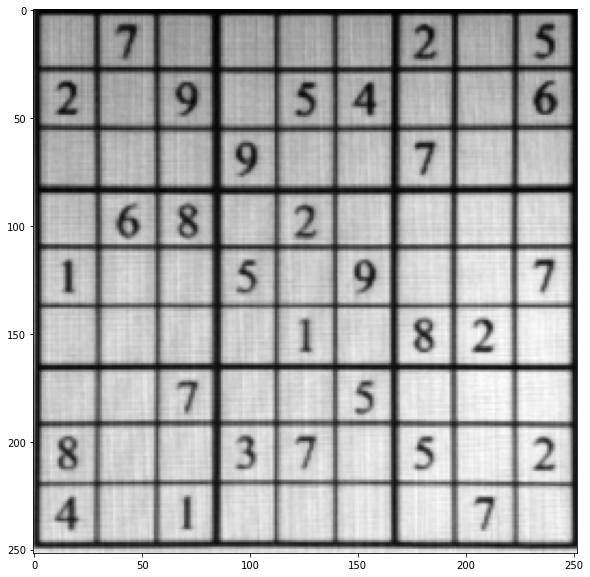

In [18]:
imshow(dst)

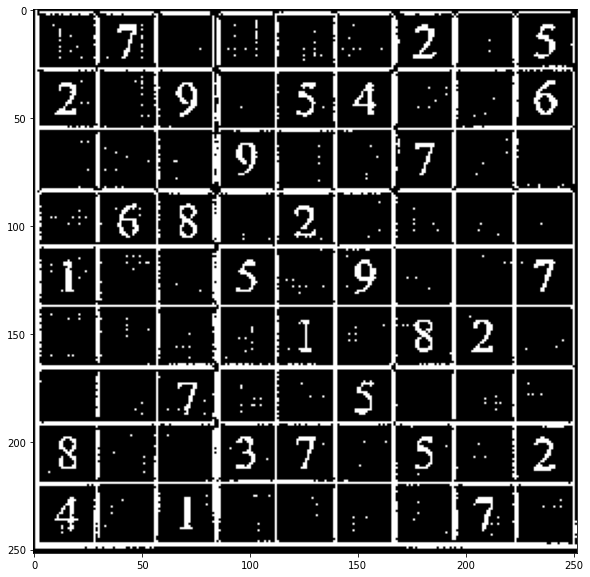

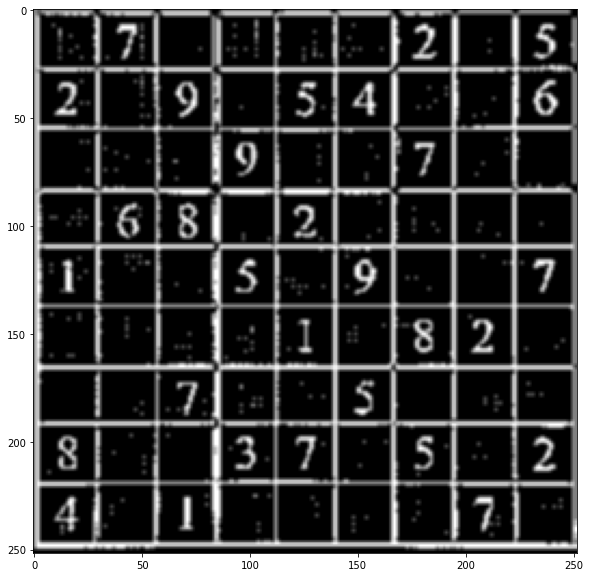

In [19]:
q = cv.adaptiveThreshold(dst, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 3, 5)
imshow(q)
q = cv.GaussianBlur(q, (3, 3), 0)
imshow(q)

In [20]:
from collections import deque

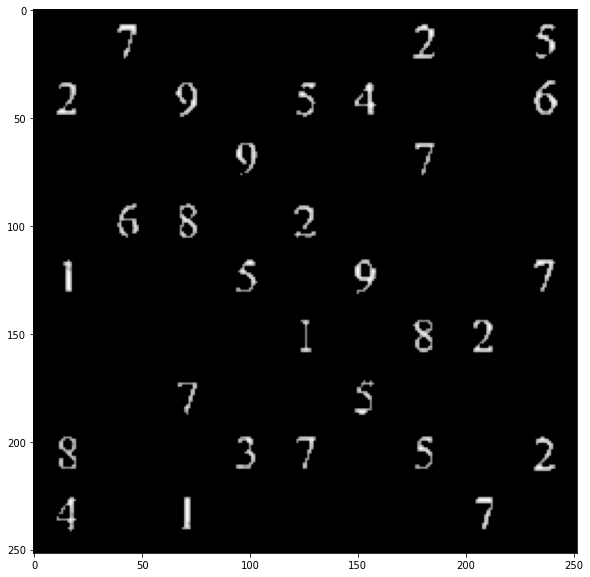

In [21]:
dst_copy = np.copy(q)
res = np.zeros_like(q)
used_mask = np.zeros_like(q)

threshold = 127
for i in range(9):
    for j in range(9):
        x = cell_size * i + cell_size // 2
        y = cell_size * j + cell_size // 2

        used_points = 0        
        points = []
        cur_point = 0
        for x_align in range(-5, 6):
            for y_align in range(-5, 6):
                new_x = x + x_align
                new_y = y + y_align
                
                used_mask[new_x, new_y] = 1
                points.append((new_x, new_y))

        while cur_point < len(points):
            x, y = points[cur_point]
            cur_point += 1

            if dst_copy[x, y] > threshold:
                res[x, y] = dst_copy[x, y]
                used_points += 1

            for x_align in range(-2, 3):
                for y_align in range(-2, 3):
                    new_x, new_y = x + x_align, y + y_align
                    if new_x >= bbox_size or new_y >= bbox_size or new_x < 0 or new_y < 0:
                        continue

                    if used_mask[new_x, new_y]:
                        continue
                    if dst_copy[new_x, new_y] > threshold:
                        used_mask[new_x, new_y] = 1
                        points.append((new_x, new_y))

        if used_points < 10:
            for point in points:
                res[point[0], point[1]] = 0
imshow(res)

In [22]:
from PIL import ImageDraw, ImageFont, Image

In [23]:
import os
import sys

In [105]:
fonts = []
base_path = "/usr/share/fonts/TTF"
for path in os.listdir(base_path):
    if not path.endswith(".ttf"):
        continue
    cur_path = os.path.join(base_path, path)
    fonts.append(ImageFont.truetype(cur_path, size=15))

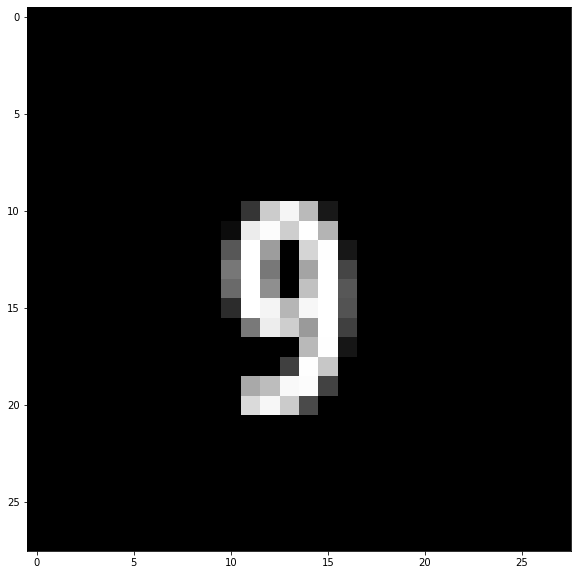

In [106]:
for font in fonts[:1]:
    with Image.new("RGB", (28, 28)) as image:
        draw = ImageDraw.Draw(image)
        draw.text((10, (28 - 15 - 4) // 2), "9", font=font, fill=(255, 255, 255))
        imshow(image)

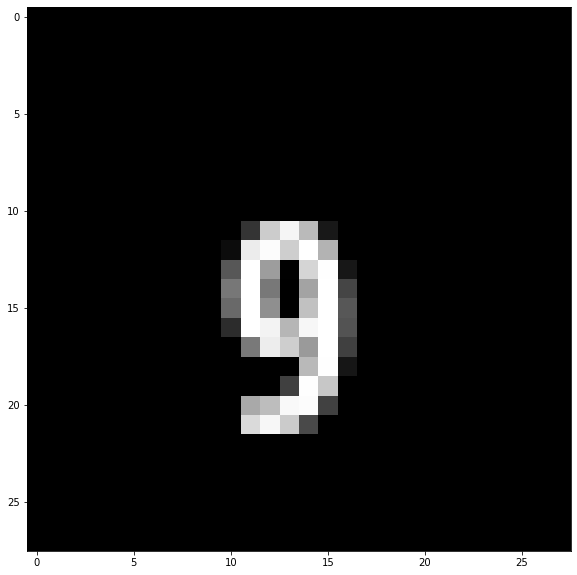

In [26]:
imshow(np.array(list(image.getdata()))[:, 0].reshape(28, 28))

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from imgaug import augmenters as iaa

In [60]:
apply_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(28),
    transforms.Pad(5, 0),
    transforms.RandomOrder([
        transforms.RandomCrop(28, fill=0),
        transforms.GaussianBlur(3),
        transforms.RandomAdjustSharpness(2, p=0.1),
        transforms.RandomRotation(15),
    ]),
    transforms.ToTensor(),
])

In [61]:
# apply_transforms = transforms.Compose([
#     iaa.Sequential([
#         iaa.flip.Fliplr(p=0.5),
#         iaa.flip.Flipud(p=0.5),
#         iaa.GaussianBlur(sigma=(0.0, 0.1)),
#         iaa.MultiplyBrightness(mul=(0.65, 1.35)),
#     ]).augment_image,
#     transforms.ToTensor(),
# ])

In [62]:
from torch.utils.data import Dataset

In [122]:
class TypedDigits(Dataset):
    def __init__(self, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        fonts = []
        base_path = "/usr/share/fonts/TTF"
        for path in os.listdir(base_path):
            if not path.endswith(".ttf"):
                continue
            cur_path = os.path.join(base_path, path)
            for font_size in range(13, 20):
                cur_font = ImageFont.truetype(cur_path, size=font_size)
                for label in range(10):
                    image = Image.new("RGB", (28, 28))
                    draw = ImageDraw.Draw(image)
                    draw.text((10, (28 - font_size - 4) // 2), str(label), font=cur_font, fill=(255, 255, 255))
                    self.samples.append(image)
                    self.labels.append(label)
            pass
#         self.samples = np.array(self.samples)
        self.samples = self.samples * 10
        self.labels = self.labels * 10
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        return (sample, label)

In [123]:
mnist_train = datasets.MNIST(root="data", train=True, download=True, transform=apply_transforms)
mnist_test = datasets.MNIST(root="data", train=False, download=True, transform=apply_transforms)
typed_digits = TypedDigits(transform=apply_transforms)

In [124]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [125]:
len(typed_digits), len(mnist_train)

(32900, 60000)

In [126]:
# mnist_train = datasets.SVHN(root="data", download=True, transform=apply_transforms)

In [158]:
train_dataloader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
train_typed_dataloader = DataLoader(typed_digits, batch_size=128, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=128, shuffle=True, num_workers=4)

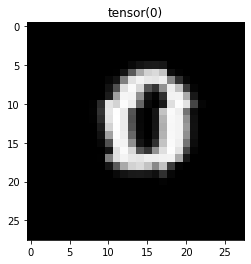

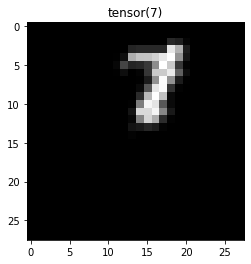

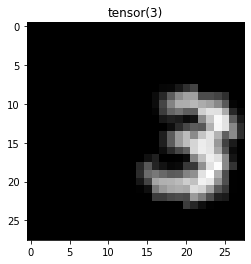

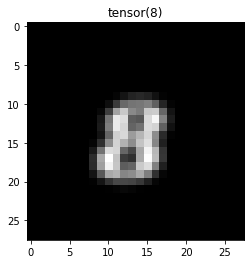

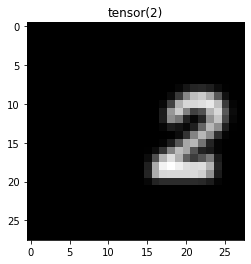

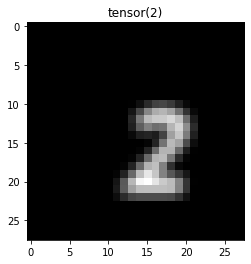

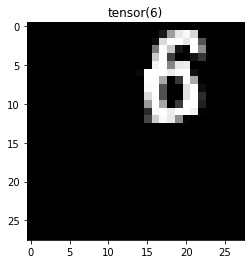

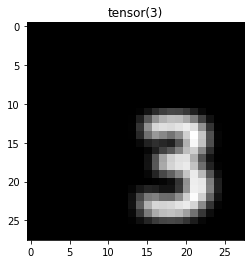

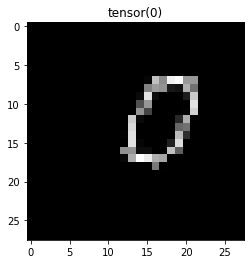

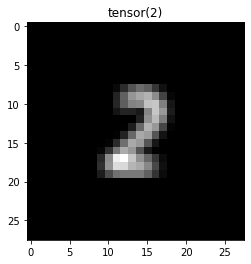

In [159]:
for X, y in train_typed_dataloader:
    for i in range(10):
        plt.imshow(X[i, 0], cmap="gray")
        plt.title(y[i])
        plt.show()
    break

In [160]:
# plt.hist(X[0, 0]);

In [161]:
# plt.hist(dst_copy);

In [162]:
from torchsummary import summary

In [163]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (28 // 8) ** 2, out_features=64),
            nn.ReLU(),
            nn.Linear(64, out_features=10),
        )

    def forward(self, x):
        return self.model(x)

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
# device = torch.device("cpu")

In [177]:

cnn_model = Model()
# net_model = Net()

summary(cnn_model.to(device), (1, 28, 28))
# summary(net_model.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 28, 28]               2
            Conv2d-2            [-1, 3, 28, 28]              78
              ReLU-3            [-1, 3, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             224
              ReLU-5            [-1, 8, 28, 28]               0
         MaxPool2d-6            [-1, 8, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           1,168
              ReLU-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 32, 14, 14]           4,640
             ReLU-10           [-1, 32, 14, 14]               0
        MaxPool2d-11             [-1, 32, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          18,496
             ReLU-13             [-1, 64, 7, 7]               0
        MaxPool2d-14             [-1, 6

In [178]:
from tqdm.notebook import tqdm

In [179]:
def train(dataloader, model, loss_fn, optimizer, additionalDataloader=None):
    size = len(dataloader.dataset)
    model.train()
    
    def getAdditionalBatch():
        while True:
            for (X_a, y_a) in additionalDataloader:
                yield (X_a, y_a)
    
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False)):
        X, y = X.to(device), y.to(device)
        if additionalDataloader is not None:
            X_a, y_a = next(getAdditionalBatch())
            X_a, y_a = X_a.to(device), y_a.to(device)
            X = torch.concat([X, X_a], dim=0)
            y = torch.concat([y, y_a], dim=0)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [180]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [181]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

In [182]:
cnn_model.to(device)
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, cnn_model, loss_fn, optimizer, train_typed_dataloader)
    test(test_dataloader, cnn_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.382202 

Epoch 2
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 93.7%, Avg loss: 0.221921 

Epoch 3
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.136384 

Epoch 4
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 95.9%, Avg loss: 0.135456 

Epoch 5
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 96.9%, Avg loss: 0.102478 

Epoch 6
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 96.9%, Avg loss: 0.092768 

Epoch 7
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.084359 

Epoch 8
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.075420 

Epoch 9
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.076218 

Epoch 10
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 98.1%, Avg loss: 0.061934 

Epoch 11
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.073566 

Epoch 12
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 98.2%, Avg loss: 0.057829 

Epoch 13
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 98.1%, Avg loss: 0.065972 

Epoch 14
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 97.9%, Avg loss: 0.065656 

Epoch 15
-------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.050070 

Done!


In [186]:
cnn_model.eval().to(device)

Model(
  (model): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): ReLU()
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=1152, out_features=64,

tensor(7, device='cuda:0')


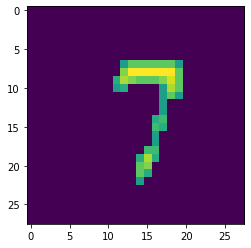

tensor(2, device='cuda:0')


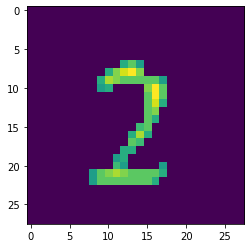

tensor(5, device='cuda:0')


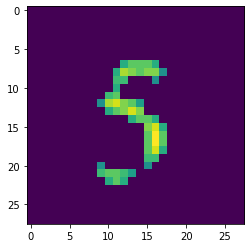

tensor(2, device='cuda:0')


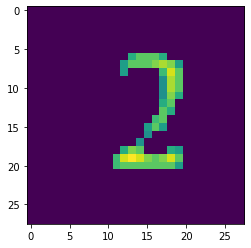

tensor(9, device='cuda:0')


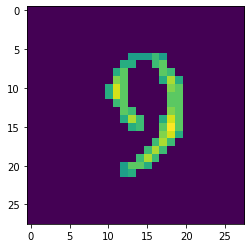

tensor(5, device='cuda:0')


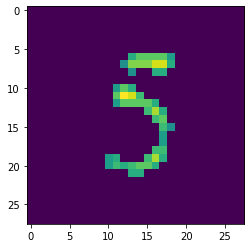

tensor(4, device='cuda:0')


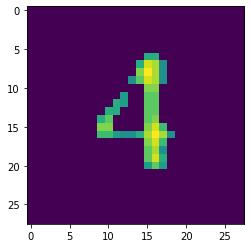

tensor(6, device='cuda:0')


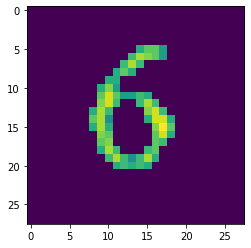

tensor(9, device='cuda:0')


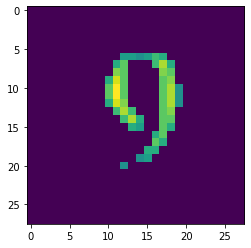

tensor(7, device='cuda:0')


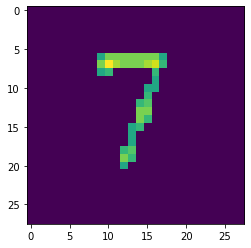

tensor(6, device='cuda:0')


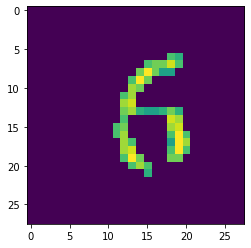

tensor(8, device='cuda:0')


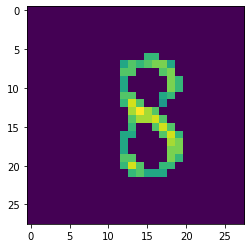

tensor(2, device='cuda:0')


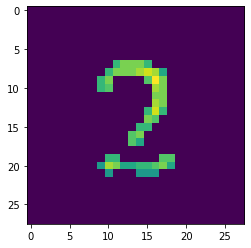

tensor(1, device='cuda:0')


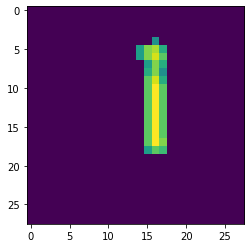

tensor(5, device='cuda:0')


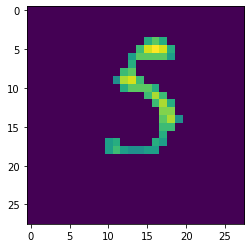

tensor(9, device='cuda:0')


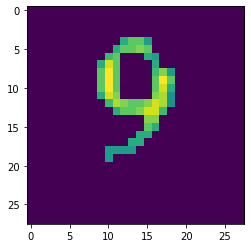

tensor(7, device='cuda:0')


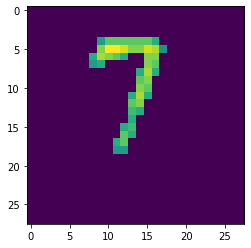

tensor(1, device='cuda:0')


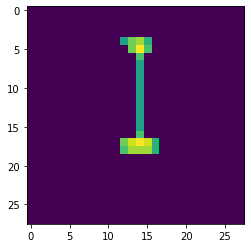

tensor(8, device='cuda:0')


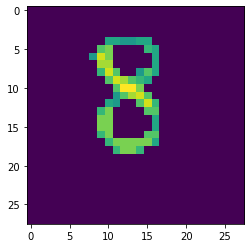

tensor(2, device='cuda:0')


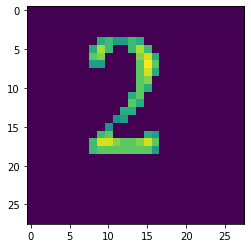

tensor(7, device='cuda:0')


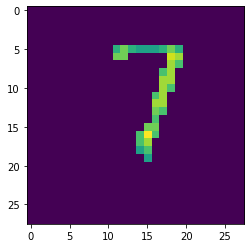

tensor(5, device='cuda:0')


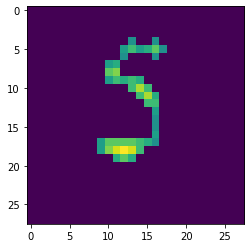

tensor(8, device='cuda:0')


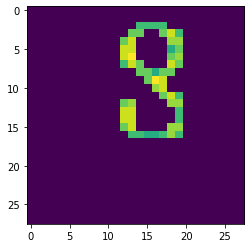

tensor(3, device='cuda:0')


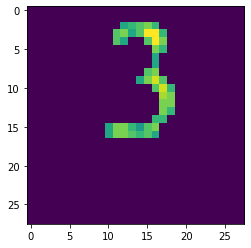

tensor(7, device='cuda:0')


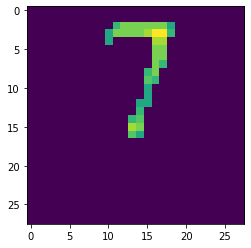

tensor(5, device='cuda:0')


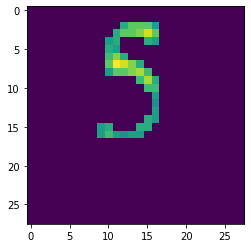

tensor(2, device='cuda:0')


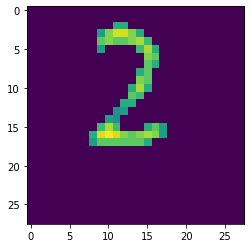

tensor(4, device='cuda:0')


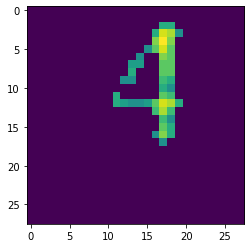

tensor(1, device='cuda:0')


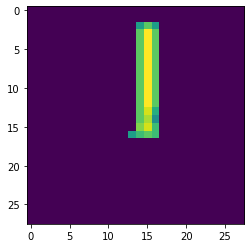

tensor(7, device='cuda:0')


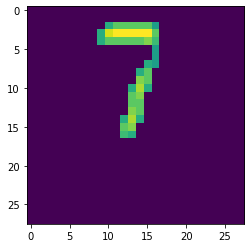

In [187]:
cnn_model.to(device)
for row in range(9):
    for col in range(9):
        sub_img = res[cell_size * row: cell_size * (row + 1), cell_size * col: cell_size * (col + 1)] / 255
        if sub_img.sum() < 10:
            continue
        predict = cnn_model.forward(torch.Tensor(sub_img).reshape(1, 1, 28, 28).to(device))
        print(torch.argmax(predict))
        plt.imshow(sub_img)
        plt.show()

In [188]:
from torch.utils.mobile_optimizer import optimize_for_mobile

base_name = "cnn_with_typed_digits_diff_font_size_v2"

torch.save(cnn_model, f"{base_name}.pth")
scripted_module = torch.jit.script(cnn_model.to(torch.device("cpu")))
scripted_module._save_for_lite_interpreter(f"{base_name}_not_optimized.ptl")